In [1]:
!pip3 install matplotlib
!pip3 install numpy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 + 4*x + 5

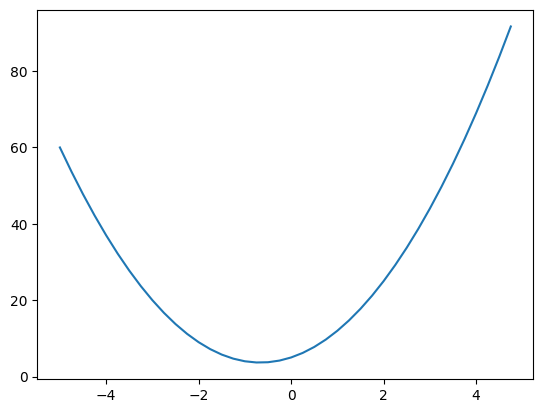

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [23]:
# derivative function = f(x + h) - f(x) / h
h = 0.00001
x = 4
slope = (f(x + h) - f(x)) / h
slope

28.000029998054284

In [28]:
a = 3
x = 4
b = 5
v1 = a * x + b
print(v1)
h = 0.000001
b += h
v2 = a * x + b
dvda = (v2 - v1) / h
print(dvda)

17
1.0000000010279564


In [5]:
class Value:
  def __init__(self, data, _children = (), label = ""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self.label = label

  def __repr__(self):
    return f"Value(data = {self.data})"
    
  def __add__(self, other):
    other = self.get_other(other)
    out = Value(self.data + other.data, (self, other), "+")
  
    def _backward():
      self.grad += out.grad
      other.grad += out.grad

    out._backward = _backward
    return out
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad

    out._backward = _backward

    return out
  
  def __truediv__(self, other):
    return self * other**-1
  
  def __mul__(self, other):
    other = self.get_other(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data

    out._backward = _backward

    return out
  
  def __rdiv__(self, other):
    return self / other
  
  def __rmul__(self, other):
    return self * other
  
  def __radd__(self, other):
    return self + other
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t ** 2) * out.grad

    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), "exp")

    def _backward():
      self.grad += out.data * out.grad
      
    out._backward = _backward
    
    return out
  
  def get_other(self, value):
    return value if isinstance(value, Value) else Value(value)

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    
    build_topo(self)

    self.grad = 1
    
    for node in reversed(topo):
      node._backward()

    
  
a = Value(3)
b = Value(4)
c = Value(5)
d = a * b
e = d + c
print(d)
print(e)
print(d._prev)
print(e._prev)
print(d.label)
print(e.label)

Value(data = 12)
Value(data = 17)
{Value(data = 3), Value(data = 4)}
{Value(data = 12), Value(data = 5)}
*
+


In [6]:
def lol():
  h = 0.0000001

  a = Value(2, label="a")
  b = Value(-3, label="b")
  c = a * b; c.label = "c"
  d = Value(10, label="d")
  e = c + d; e.label = "e"
  f = Value(-2, label = "f")
  L = e * f; L.label = "L"
  L1 = L.data

  a = Value(2, label="a")
  b = Value(-3, label="b")
  c = a * b; c.label = "c"
  d = Value(10, label="d")
  e = c + d; e.label = "e"
  f = Value(-2 + h, label = "f")
  L = e * f; L.label = "L"
  L2 = L.data

  dLdx = (L2 - L1)/ h
  print(dLdx)

lol()

4.000000002335469


In [262]:
# single optimization example

# storing the gradients
a = Value(2, label="a")
b = Value(-3, label="b")
c = a * b; c.label="c"
d = Value(10, label="d")
e = c + d; e.label="e"
f = Value(-2, label="f")
L = e * f; L.label="L"

a.grad = 6
b.grad = -4
c.grad = -2
d.grad = -2
e.grad = -2
f.grad = 4
L.grad = 1

# This is just for a single dendrite (weight * input) on an ultimate output 

a.data += a.grad * 0.01
b.data += b.grad * 0.01
d.data += d.grad * 0.01
f.data += f.grad * 0.01

c = a * b
e = c + d
L = e * f

print(L)


Value(data = -7.286496)


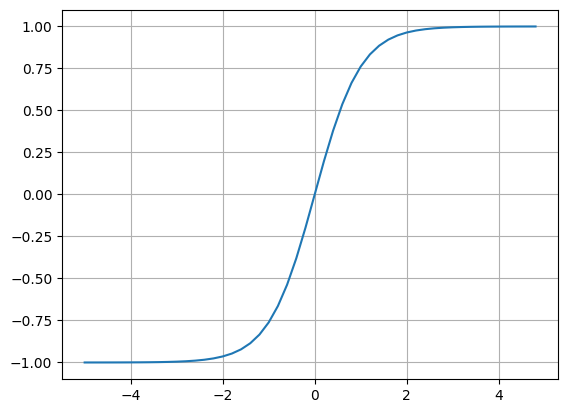

In [255]:
# tanh activation function plot

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [399]:
# for an actual neuron, which has multiple dendrites (weight * input)

#inputs
x1 = Value(2, label="x1")
x2 = Value(0, label="x2")

# weights
w1 = Value(-3, label="w1")
w2 = Value(1, label="w2")

#bias
b = Value(6.8813735870195432, label="b")

#x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
neg_n = n * -1
an = (n.exp() - neg_n.exp()) / (n.exp() + neg_n.exp())
an2 = n.tanh(); an.label = "an"
print(n, "N")
print(an, "AN")
print(an2, "AN2")

Value(data = 0.8813735870195432) N
Value(data = 0.7071067811865476) AN
Value(data = 0.7071067811865476) AN2


In [397]:
# # filling in neuron gradients

# # n gradient with respect to tanh activation (calculation)
# n_grad = 1 - an.data **2

# use backward function to
# 1. recursively add the children (DFS)
# 2. take the reverse of that list to do backward gradient prop starting with parent

an2.backward()
print(an2.grad, "AN")
print(n.grad, "N")
print(x1w1x2w2.grad, "X1W1X2W2")
print(b.grad, "B")
print(x1w1.grad, "X1W1")
print(x2w2.grad, "X2W2")
print(x1.grad, "X1")
print(w1.grad, "W1")
print(x2.grad, "X2")
print(w2.grad, "W2")

# an.backward()
# # check answers
# print(an.grad, "AN")
# print(n.grad, "N")
# print(x1w1x2w2.grad, "X1W1X2W2")
# print(b.grad, "B")
# print(x1w1.grad, "X1W1")
# print(x2w2.grad, "X2W2")
# print(x1.grad, "X1")
# print(w1.grad, "W1")
# print(x2.grad, "X2")
# print(w2.grad, "W2")

1 AN
0.4999999999999999 N
0.4999999999999999 X1W1X2W2
0.4999999999999999 B
0.4999999999999999 X1W1
0.4999999999999999 X2W2
-1.4999999999999996 X1
0.9999999999999998 W1
0.4999999999999999 X2
0.0 W2


In [309]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
print(a,b,d,e,f)

print(a.grad)
print(b.grad)
print(d.grad)
print(e.grad)
print(f.grad)


f
d
e
a
b
Value(data = -2.0) Value(data = 3.0) Value(data = -6.0) Value(data = 1.0) Value(data = -6.0)
-3.0
-8.0
1.0
-6.0
1


In [615]:
# Pytorch example
import torch

#requires gradient, default doesn't require for leaf nodes (inputs)
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]); b.requires_grad = True
n = x1*w1 + x2*w2 + b
an = torch.tanh(n)

print(an.data.item())
an.backward()

#similar flow a. create variables with equation then b. do output with grad 1 output.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
torch.Tensor([1,2,3],[4,5,6])

In [7]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi * xi for wi, xi in list(zip(self.w, x))), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x)for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return[p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [25]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [[1.0, 2.0], [-1.0, -2.0], [-1.0, -2.0], [1.0, 2.0]]

In [36]:
# Instantiating the multi layer perceptron

# 3 inputs 
x = [2.0, 3.0, -1.0]

# Layer takes in 3 inputs (instantiate weights), and has 4 output nodes
layer = Layer(3, 4)
l = layer(x)
print(l)

# MLP has 3 input nodes, and an array of other layers lengths
# x is taken and fed through each layer with in/out lengths (3,4), (4,4), (4,1)
mlp = MLP(3, [4, 4, 2])
mlp(x)

[Value(data = 0.9976126311044018), Value(data = -0.722589418400989), Value(data = 0.9846426654200576), Value(data = -0.9792570651396703)]


[Value(data = 0.5256324088316349), Value(data = -0.1342937468820054)]

In [10]:
# loss function - sum of (y pred - y actual) ^ 2
ypred = [mlp(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data = 5.344995593266024)

In [11]:
# fills in all gradients
# weight should have gradient 0
w1g_empty = mlp.layers[0].neurons[0].w[0].grad
print(w1g_empty, "should be 0")

# runs backward propagation from outputs loss function loss > 4 mlp outs > all layer (output, hidden) forward prop x * w + b functions 
loss.backward()

# should have gradient not 0
w1g_filled = mlp.layers[0].neurons[0].w[0].grad
print(w1g_filled, "should not be 0")

0.0 should be 0
0.03779550113893923 should not be 0


In [13]:
# you can see that the mlp has weights and biases for specific neurons
w11 = mlp.layers[0].neurons[0].w
b11 = mlp.layers[0].neurons[0].b
print(w11, b11, "weights and bias of first neuron of first layer")

# looks at all the weights and biases of a neural networks
params = mlp.parameters()

# 41 parameters (3 * 4 weights + 4 * 4 weights + 4 * 1 weights + (4 + 4 + 1) biases)
print(len(mlp.parameters()))

[Value(data = 0.2775305545397597), Value(data = 0.719044364294259), Value(data = -0.6872440000755566)] Value(data = -0.6079424679035419) weights and bias of first neuron of first layer
41


In [14]:
# nudge all the parameters (value.data) by 0.01 learning rate * gradient (value.grad)

for p in mlp.parameters():
  p.data += -0.01 * p.grad

In [15]:
# calculate loss again and it should have gone down
# you can keep adjusting weights by gradient to decrease loss

ypred = [mlp(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
print(loss, "LOSS")
print(ypred, "predictions")


Value(data = 4.578112589760119) LOSS
[Value(data = -0.5250897089949224), Value(data = -0.6930262054536974), Value(data = -0.6457108288899971), Value(data = -0.42564379912162253)] predictions


In [ ]:
# actual training loop

for k in range(200):
  # forward pass
  ypred = [mlp(x) for x in xs]

  loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

  # backward pass
  # we need to zero the gradients every time we do backward pass to calculate new gradients with new params, but same
  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in mlp.parameters():
    p.data += -.05 * p.grad

  print(loss.data)

0.5106118800663055
0.5105569606569892
0.5105026018597989
0.5104487951843404
0.5103955323101035
0.510342805082248
0.5102906055075124
0.5102389257502439
0.510187758128546
0.510137095110535
0.5100869293107079
0.5100372534864142
0.5099880605344287
0.509939343487623
0.50989109551173
0.5098433099022028
0.5097959800811593
0.5097490995944148
0.5097026621085956
0.509656661408334
0.509611091393541
0.5095659460767529
0.5095212195805527
0.5094769061350592
0.5094330000754876
0.5093894958397727
0.5093463879662586
0.50930367109145
0.5092613399478215
0.5092193893616885
0.5091778142511316
0.5091366096239769
0.5090957705758297
0.5090552922881578
0.5090151700264274
0.5089753991382848
0.5089359750517862
0.508896893273673
0.5088581493876905
0.5088197390529503
0.5087816580023332
0.5087439020409343
0.5087064670445443
0.5086693489581722
0.5086325437946013
0.5085960476329847
0.508559856617473
0.5085239669558765
0.5084883749183605
0.5084530768361724
0.5084180691003994
0.5083833481607573
0.5083489105244072
0.508